In [27]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())


In [28]:
#formatted date for the chart titles
now = datetime.now()
formatted_current_date =now.strftime("%m/%d/%Y")

In [29]:
def get_sentiments(target_user):
    
    # Counter
    counter = 1

    # Variables for holding sentiments
    sentiments_list = []

    # Variable for max_id
    oldest_tweet = None

    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, max_id = oldest_tweet)

        # Loop through all tweets 
        for tweet in public_tweets:

            # Print Tweets
            # print("Tweet {counter}: {tweet["text"]})

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]

            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

            # Add sentiments for each tweet into a list
            sentiments_list.append({"User":target_user,"Date": tweet["created_at"], 
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neu,
                               "Neutral": neg,
                               "Tweets Ago": counter,"Message":tweet['text']})

            # Add to counter 
            counter += 1
    
    return sentiments_list

In [30]:
def get_sentiments_from_user_list(user_list):
    combined_results = []
    
    for user in user_list:
        if len(combined_results)==0:
            combined_results = get_sentiments(user)
        else:
            combined_results = combined_results + get_sentiments(user)
        
    return combined_results

In [31]:
users_list = ['@BBCWorld','@CNN','@CBSNews','@FoxNews','@nytimes']

sentiments_list = get_sentiments_from_user_list(users_list)



In [32]:
sentiments_dataframe = pd.DataFrame.from_dict(sentiments_list)
sentiments_dataframe.head()

,Compound,Date,Message,Negative,Neutral,Positive,Tweets Ago,User
0,0.0000,Sun Sep 09 02:31:11 +0000 2018,Swedish election: Vote held amid anti-immigrat...,1.000,0.000,0.000,1,@BBCWorld
1,-0.3876,Sat Sep 08 23:22:55 +0000 2018,"US trade wars: The farmers who trust Trump, bu...",0.591,0.282,0.127,2,@BBCWorld
2,0.0000,Sat Sep 08 23:20:15 +0000 2018,Sergei Skripal and the Russian disinformation ...,1.000,0.000,0.000,3,@BBCWorld
3,-0.6249,Sat Sep 08 23:11:52 +0000 2018,Families of Yemen bus strike victims despair a...,0.567,0.433,0.000,4,@BBCWorld
4,0.0000,Sat Sep 08 22:35:03 +0000 2018,North Korea to stage military parade and mass ...,1.000,0.000,0.000,5,@BBCWorld


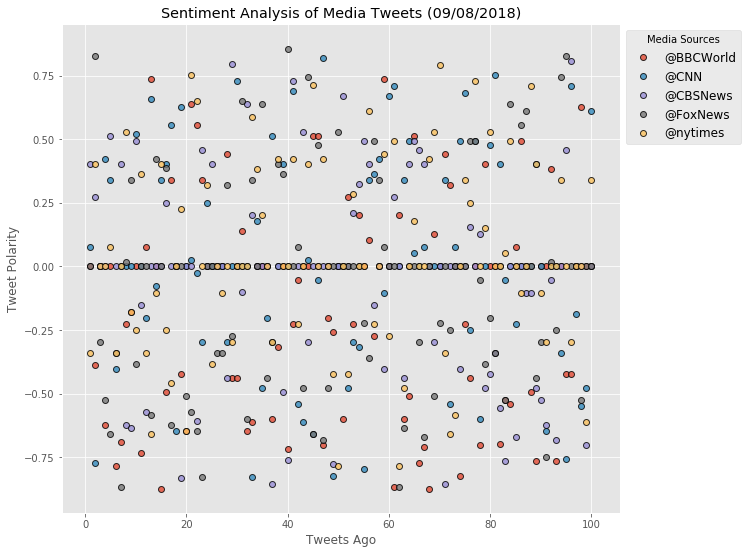

In [38]:
x_values=list(range(1,101))
x_values

fig = plt.figure(figsize=(10,9))

for user in users_list:
    
    plt.scatter(x_values, 
            sentiments_dataframe[sentiments_dataframe['User']==user]['Compound'], 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label=user)

plt.title(f'Sentiment Analysis of Media Tweets ({formatted_current_date})')
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
lgnd = plt.legend(bbox_to_anchor=(1, 1), loc=2,fontsize="large", title="Media Sources")

#, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig("sentiment_scatter.png",bbox_extra_artists=(lgnd))



In [39]:
negative_df = sentiments_dataframe[sentiments_dataframe['Compound']==0].groupby('User').count()
negative_df

,Compound,Date,Message,Negative,Neutral,Positive,Tweets Ago
User,,,,,,,
@BBCWorld,32,32,32,32,32,32,32
@CBSNews,40,40,40,40,40,40,40
@CNN,30,30,30,30,30,30,30
@FoxNews,32,32,32,32,32,32,32
@nytimes,34,34,34,34,34,34,34


In [40]:
sentiments_avg = sentiments_dataframe.groupby('User').Compound.mean()
sentiments_avg

User
@BBCWorld   -0.143651
@CBSNews    -0.044366
@CNN         0.029397
@FoxNews    -0.065491
@nytimes     0.040859
Name: Compound, dtype: float64

In [41]:
sentiments_avg.index

Index(['@BBCWorld', '@CBSNews', '@CNN', '@FoxNews', '@nytimes'], dtype='object', name='User')

In [42]:
sentiments_avg['@BBCWorld']

-0.14365100000000003

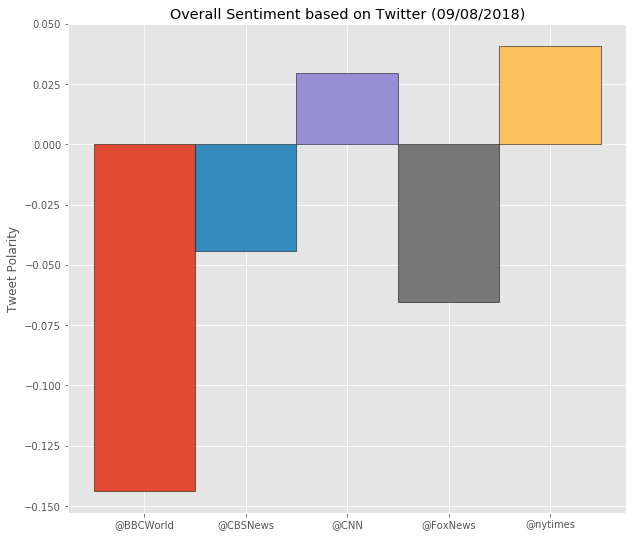

In [43]:
fig = plt.figure(figsize=(10,9))
for user in sentiments_avg.index:
    plt.bar(user,sentiments_avg[user],width=1.0,edgecolor='black')

plt.title(f'Overall Sentiment based on Twitter ({formatted_current_date})')
plt.ylabel("Tweet Polarity")
plt.savefig("overall_sentiments.png")


In [44]:
sentiments_dataframe.to_csv("sentiments.csv")